Populating the interactive namespace from numpy and matplotlib
Zero (0) frequency temperature record being processed as 1. Record:  971
Zero (0) frequency temperature record being processed as 1. Record:  972
Zero (0) frequency temperature record being processed as 1. Record:  973
Zero (0) frequency temperature record being processed as 1. Record:  974
Zero (0) frequency temperature record being processed as 1. Record:  975
Zero (0) frequency temperature record being processed as 1. Record:  976
Zero (0) frequency temperature record being processed as 1. Record:  977
Zero (0) frequency temperature record being processed as 1. Record:  978
Zero (0) frequency temperature record being processed as 1. Record:  979
Zero (0) frequency temperature record being processed as 1. Record:  980
Zero (0) frequency temperature record being processed as 1. Record:  981
Zero (0) frequency temperature record being processed as 1. Record:  982
Zero (0) frequency temperature record being processed as 1. R

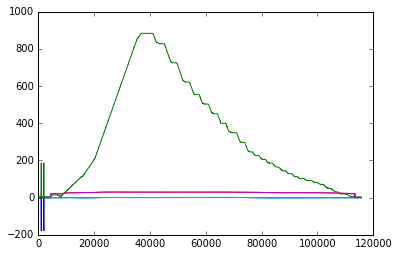

In [6]:
%pylab inline
import xml.etree.ElementTree as ET
import struct
import numpy as np
import re
#import ipdb

def parse_frequency_hex(s):
    #return int(s[0:2], 16) * 256 + int(s[2:4], 16) + int(s[4:6], 16)/256
    return int(s, 16) / 256
        
def prase_volt_hex(s):        
    return (5 * (1 - (int(s, 16) / 4095)))
        
class SBEReader():
    
    def __init__(self, raw_hex, xml_config):
        '''expects long charicter string inputs'''
        self.raw_hex = raw_hex
        self.xml_config = xml_config
        self._parse_config()
        self._load_hex()
        self._check_scan_lengths()
        
    def _load_hex(self):
        split_lines = self.raw_hex.splitlines()
        self.raw_bytes = [l.strip().encode("utf-8") for l in split_lines if not l.startswith("*")]
        
    def _check_scan_lengths(self):
        if not all([len(scan) == self.scan_length for scan in self.raw_bytes]):
            raise ValueError("The data length does not match the expected length from the config")
            
    def _parse_scans(self):
        '''The order according to the SBE docs are:
        1) Data from the instrument
          a) Frequency (3 bytes each)
          b) Voltage (12 bits each)
        2) Surface Par (3 bytes)
        3) NMEA lat/lon (7 bytes)
        4) NMEA depth (3 bytes)
        5) NMEA time (4 bytes) (low byte first)
        6) Additional Data from the instrument
          a) Pressure temp (12 bits)
          b) pump status (4 bits)
          c) modulo byte (1 byte)
        7) System time (4 bytes) (low byte first)
        If any of the above are omitted, the length of the hex will be smaller.
        '''
        
        # parse the frequencies
        #scan_list = list(scan)
        num_frequencies = 5 - self.config["FrequencyChannelsSuppressed"]
        num_voltages = 8 - self.config["VoltageWordsSuppressed"]
        
        the_bytes = b"".join(self.raw_bytes)
        
        unpack_str = "6s" * num_frequencies + "3s" * num_voltages + "{}s".format(self.scan_length - num_voltages * 3 - num_frequencies * 6)
        measurements = np.array([[int(x, 16) for x in line] for line in struct.iter_unpack(unpack_str, the_bytes)])

        #this uses numpy magic to just "apply" the needed operations to the correct part of the array all in one go
        measurements[:,:num_frequencies] = measurements[:,:num_frequencies] / 256
        measurements[:,num_frequencies:num_frequencies+num_voltages] = (5 * (1 - (measurements[:,num_frequencies:num_frequencies+num_voltages] / 4095)))
        return measurements
    
    """Only for values in bools and numeric. """
    def _parse_config(self):
        bools = [
            "SurfaceParVoltageAdded",
            "NmeaPositionDataAdded",
            "NmeaDepthDataAdded",
            "NmeaTimeAdded",
            "ScanTimeAdded",
        ]
        numeric = [
            "FrequencyChannelsSuppressed",
            "VoltageWordsSuppressed",
            ]

        config = ET.fromstring(self.xml_config)
        self.config = {}
        
        for key in numeric:
            try:
                self.config[key] = int(config.find("./Instrument/{}".format(key)).text)
            except AttributeError:
                raise AttributeError("Could not find {} in XMLCONF".format(key))
            except ValueError:
                raise ValueError("{} Value is not a number".format(key))

        for key in bools:
            try:
                self.config[key] = bool(int(config.find("./Instrument/{}".format(key)).text))
            except AttributeError:
                raise AttributeError("Could not find {} in XMLCONF".format(key))
            except ValueError:
                raise ValueError("{} Value is not truthy".format(key))
    
    @classmethod
    def from_paths(cls, raw_hex_path, xml_config_path, encoding="cp437"):
        with open(raw_hex_path, encoding=encoding) as raw_hex_file, open(xml_config_path, encoding=encoding) as xml_config_file:
            return cls(raw_hex_file.read(), xml_config_file.read())
    
    @property
    def scan_length(self):
        return self.calculate_scan_byte_length()
    
    @property
    def frequency_channels(self):
        pass
    
    def voltage_channels(self):
        pass
    
    def calculate_scan_byte_length(self):
        length = 6 # Extra info alway present takes 6 "chars"
        length += 6 * (5 - self.config["FrequencyChannelsSuppressed"])
        length += 3 * (8 - self.config["VoltageWordsSuppressed"])
        length += 8 * self.config["ScanTimeAdded"]
        length += 8 * self.config["NmeaTimeAdded"]
        length += 6 * self.config["NmeaDepthDataAdded"]
        length += 14 * self.config["NmeaPositionDataAdded"]
        length += 6 * self.config["SurfaceParVoltageAdded"]
        return int(length)
    
    @property
    def parsed_scans(self):
        try:
            return self._parsed_scans
        except AttributeError:
            self._parsed_scans = self._parse_scans()
            return self._parsed_scans
        
    def to_dict(self, parse_cache=True):
        return {
            "raw_hex": self.raw_hex,
            "xml_config": self.xml_config,
            "_parsed_scans": self.parsed_scans,
            }
    
    @classmethod
    def from_dict(cls, data):
        instance = cls(data["raw_hex"], data["xml_config"])
        try:
            instance._parsed_scans = data["_parsed_scans"]
        except KeyError:
            pass
        return instance

def temp_its90_dict(calib, freq):
    """SBE equation for converting engineering units to Celcius according to ITS-90.
    calib is a dict holding G, H, I, J, F0
    G, H, I, J, F0: coefficients given in calibration.
    f: frequency sampled by sensor, either as a single value or a list or tuple.

    Original form from calib sheet dated 2012:
    Temperature ITS-90 = 1/{g+h[ln(f0/f )]+i[ln2(f0/f)]+j[ln3(f0/f)]} - 273.15 (°C)

    """
    f = freq
    #array mode
    try:
        ITS90 = []
        for i, f_x in enumerate(f):
            #Hack for dealing with 0 frequencies, needs additional reporting later
            if f_x == 0:
                f_x = 1
                print("Zero (0) frequency temperature record being processed as 1. Record: ", i)
            temp = 1/(calib['G'] 
                      + calib['H'] * (math.log(calib['F0']/f_x)) 
                      + calib['I'] * math.pow((math.log(calib['F0']/f_x)),2) 
                      + calib['J'] * math.pow((math.log(calib['F0']/f_x)),3)
                     ) - 273.15
            temp = round(temp,4)
            ITS90.append(temp)
    #single mode
    except:
        if f == 0:
            f = 1
            print("Zero (0) frequency temperature record [singleton] being processed.")
        ITS90 = 1/(calib['G'] 
                   + calib['H'] * (math.log(calib['F0']/f)) 
                   + calib['I'] * math.pow((math.log(calib['F0']/f)),2) 
                   + calib['J'] * math.pow((math.log(calib['F0']/f)),3)
                  ) - 273.15
        ITS90 = round(ITS90,4)
    return ITS90

def OxSol(T,S):
    """Eq. 8 from Garcia and Gordon, 1992.

    Inputs:
    T = ITS-90 Temperature
    S = Practical Salinity
    """

    x = S
    y = math.log((298.15 - T)/(273.15 + T))

    """umol/kg coefficients
    a0 =  5.80871
    a1 =  3.20291
    a2 =  4.17887
    a3 =  5.10006
    a4 = -9.86643e-2
    a5 =  3.80369
    b0 = -7.01577e-3
    b1 = -7.70028e-3
    b2 = -1.13864e-2
    b3 = -9.51519e-3
    c0 = -2.75915e-7

    """

    """ml/l coefficients"""
    a0 = 2.00907
    a1 = 3.22014
    a2 = 4.05010
    a3 = 4.94457
    a4 = -2.56847e-1
    a5 = 3.88767
    b0 = -6.24523e-3
    b1 = -7.37614e-3
    b2 = -1.03410e-2
    b3 = -8.17083e-3
    c0 = -4.88682e-7

    O2sol = math.exp(a0 + y*(a1 + y*(a2 + y*(a3 + y*(a4 + a5*y)))) + x*(b0 + y*(b1 + y*(b2 + b3*y)) + c0*x))
    return O2sol

def oxy_dict(calib, P, K, T, S, V):
    """SBE equation for converting engineering units to oxygen (ml/l).

    calib is a dict holding Soc, Voffset, Tau20, A, B, C, E
    The following are single or list/tuple:
    P is pressure in decibars
    K is temperature in Kelvin
    T is temperature in Celcius
    S is Practical Salinity Units
    V is Voltage from instrument

    Original equation from calib sheet dated 2014:
    Oxygen (ml/l) = Soc * (V + Voffset) * (1.0 + A * T + B * T + C * T ) * OxSol(T,S) * exp(E * P / K)

    """
    
    """Assumes all are arrays, or none are arrays. Need way to test for them. """
    try:
        oxygen = []
        for P_x, K_x, T_x, S_x, V_x in zip(P, K, T, S, V):
            temp = (calib['Soc'] * (V_x + calib['offset'])
                    * (1.0 + calib['A'] * T_x + calib['B'] * math.pow(T_x,2) + calib['C'] * math.pow(T_x,3) )
                    * OxSol(T_x,S_x) 
                    * math.exp(calib['E'] * P_x / K_x)) #foo
            temp = round(temp,4)
            oxygen.append(temp)
    #Single mode.
    except:
        oxygen = (calib['Soc'] * (V + calib['offset']) 
                  * (1.0 + calib['A'] * T + calib['B'] * math.pow(T,2) + calib['C'] * math.pow(T,3) ) 
                  * OxSol(T,S) 
                  * math.exp(calib['E'] * P / K))
    return oxygen

def cond_dict(calib, F, t, p):
    """SBE equation for converting frequency to conductivity.

    Inputs:
    
    G: coefficient
    H: coefficient
    I: coefficient
    J: coefficient
    CPcor: coefficient (nominal)
    CTcor: coefficient (nominal)

    F: instrument frequency
    t: temperature (ITS-90 degrees C)
    p: pressure (decibars)
    """
    try:
        Conductivity = []
        f = [x/1000 for x in F]
        for F_0, t_0, p_0 in zip(f, t, p):
            temp = ((calib['G'] + calib['H'] * math.pow(F_0,2)
                     + calib['I'] * math.pow(F_0,3)
                     + calib['J'] * math.pow(F_0,4))
                    / (1 + calib['CTcor'] * t_0 + calib['CPcor'] * p_0))
            temp = round(temp, 5)
            Conductivity.append(temp)
    #single mode
    except:
        f = F/1000
        Conductivity = ((calib['G'] + calib['H'] * math.pow(f,2)
                         + calib['I'] * math.pow(f,3)
                         + calib['J'] * math.pow(f,4))
                        / (1 + calib['CTcor'] * t + calib['CPcor'] * p))
        Conductivity = round(Conductivity,5)
    return Conductivity

def pressure_dict(calib, f, t):
    """SBE/STS(?) equation for converting pressure frequency to temperature.
    
    Inputs:
    calib is a dictionary of coefficients
    T1: coefficient
    T2: coefficient
    T3: coefficient
    T4: coefficient
    T5: not used
    C1: coefficient
    C2: coefficient
    C3: coefficient
    D1: coefficient
    D2: coefficient
    AD590M: not used
    AD590B: not used
    
    f: sensor frequency (usually between 30kHz and 42kHz)
    t: sensor temperature in C
    
    """
    #array mode
    try:
        pressure = []
        """Equation expecting pressure period in microseconds, so divide f by 1,000,000. """
        uf = [x/1000000 for x in f]
        for f_x, t_x in zip(uf, t):
            T0 = calib['T1'] + calib['T2']*t_x + calib['T3']*math.pow(t_x,2) + calib['T4']*math.pow(t_x,3)
            w = 1-T0*T0*f_x*f_x
            temp = (0.6894759*((calib['C1']+calib['C2']*t_x+calib['C3']*t_x*t_x)*w*(1-(calib['D1']+calib['D2']*t_x)*w)-14.7))
            pressure.append(round(temp,2))
    #single mode
    except:
        T0 = calib['T1'] + calib['T2']*t + calib['T3']*math.pow(t,2) + calib['T4']*math.pow(t,3)
        w = 1-T0*T0*f*f
        pressure = (0.6894759*((calib['C1']+calib['C2']*t+calib['C3']*t*t)*w*(1-(calib['D1']+calib['D2']*t)*w)-14.7))
    return pressure

def wetlabs_flrtd_chl_dict(calib, counts):
    """Wetlabs 
    
    """
    chl = calib['scale_factor'] * (output - calib['darkcounts'])
    return chl

def wetlabs_transmissometer_cstar_dict(calib, signal):
    """Wetlabs CStar Transmissiometer.
    Equation from calib sheet for S/N#: CST-479-DR, Date: October 31, 2014
    
    Inputs: 
    calib is a dictionary of constants/coefficients
        calib['dark'] = voltage when beam is blocked. V_d on calib sheet
        calib['air'] = voltage with clear beam path in air. V_air on calib sheet
        calib['reference'] = voltage with beam path in clean water. V_ref on calib sheet
    signal: dict/single of signal voltage
    
    Relationship of transmittance (Tr) to beam attenuation coefficient (c), and pathlength (x, in meters): Tr = e^-ex
    beam attenuation coefficient is determined as: c = -1/x * ln (Tr)
    
    """
    
    #array mode
    try:
        tx = []
        for signal_x in signal:
            temp = (signal_x - calib['dark'])/(calib['reference'] - calib['dark'])
            tx.append(temp)
    #single mode
    except:
        tx = (signal - calib['dark'])/(calib['reference'] - calib['dark'])
    return tx

def benthos_psa916_dict(calib, signal):
    """Equation for determining altitude from a Benthos PSA-916 altimeter.
    Equation provided by SBE as AN95, or here: http://www.seabird.com/document/an95-setting-teledyne-benthos-altimeter-sea-bird-profiling-ctd
    Equation stated as: altimeter height = [300 * voltage / scale factor] + offset
    
    Inputs:
    calib is a dictionary of coefficients
        calib['ScaleFactor']: scaling factor to be applied
        calib['Offset']: offset to be applied
    
    signal: signal voltage 
    """
    
    #array mode
    try:
        altitude = []
        for signal_x in signal:
            temp = (300 * signal_x / calib['ScaleFactor']) + calib['Offset']
            altitude.append(temp)
    #single mode
    except:
        altitude = (300 * signal / calib['ScaleFactor']) + calib['Offset']
    return altitude
    
    
###
def sbe_xml_reader_a(file):
    """Function to read .XMLCON file from Seabird.

    Input:
    file: .XMLCON file produced from Seasave 7.

    Output:
    Dictionary of dictionary of sensors.

    """
    tree = ET.parse(file)
    root = tree.getroot()

    """Pokedex is a dict of {Sensor index numbers from the config:sensor info}
    Assume that sensor index number is the order the sensors have been entered into the file.
    Therefore, it will be Frequency instruments first, then Voltage instruments.
    Call their index number (starting at 0) in order to pull out the info.

    """
    pokedex = {}
    for x in root.iter('Sensor'):
        """Start creating single sensor dictionary."""
        bulbasaur = {}
        bulbasaur['SensorID'] = x.attrib['SensorID']
        #load all values into dict - beware of overwriting #NEED TO FIX
        for children in x:
            for y in children.iter():
                bulbasaur[y.tag] = float_convert(y.text)
            """Add sensor to big dictionary."""
            pokedex[x.attrib['index']] = bulbasaur
    return pokedex
 
def float_convert(string):
    try:
        return float(string)
    except:
        return string

    ######################### Change filenames here #######################
    
    
sbe_reader = SBEReader.from_paths("GS3601101.hex", "GS3601101.XMLCON")
    
    
    ######################### Change filenames here #######################

temperature_array_1 = sbe_reader.parsed_scans[:,0]


sensor_dictionary = sbe_xml_reader_a('GS3601101.XMLCON')
#print(sensor_dictionary)
temperature_array_1_final = temp_its90_dict(sensor_dictionary['0'], temperature_array_1)
plot(temperature_array_1_final)
pressure_array_final = pressure_dict(sensor_dictionary['2'], sbe_reader.parsed_scans[:,2],temperature_array_1_final)
plot(pressure_array_final)
conductivity_array_1_final = cond_dict(sensor_dictionary['1'], sbe_reader.parsed_scans[:,1],temperature_array_1_final, pressure_array_final)
plot(conductivity_array_1_final)
temperature_array_2_final = temp_its90_dict(sensor_dictionary['3'], sbe_reader.parsed_scans[:,3])
plot(temperature_array_2_final)
conductivity_array_2_final = cond_dict(sensor_dictionary['4'], sbe_reader.parsed_scans[:,4],temperature_array_1_final, pressure_array_final)
plot(conductivity_array_2_final)
kelvin_array = [273.15+gg for gg in temperature_array_1_final]
sbe43_array_final = oxy_dict(sensor_dictionary['7'], pressure_array_final,kelvin_array,temperature_array_1_final,conductivity_array_1_final, sbe_reader.parsed_scans[:,7])



def cnv_handler(hex_file, xmlcon_file):
    """Handler to deal with converting eng. data to sci units automatically.
    When not given a format file/json, default to putting out data in order of instruments in xmlcon.
    Format file makes assumptions: duplicate sensors are ranked by channel they use, with lower value more important.
    Ex: For two SBE 3, the temp. sensor on freq. channel 1 is primary temp, and temp. sensor on channel 4 is secondary.
    
    After reading in format/XMLCON, determine order to put out data.
    Read sensor dictionary, pull out SensorID number, then match with correct method.
    
    Read in 
    
    VALUES HARDCODED, TRY TO SETUP A DICT TO MAKE NEATER
    
    """
    sbe_reader = SBEReader.from_paths(hex_file, xmlcon_file)
    
    sensor_dictionary = sbe_xml_reader_a(xmlcon_file)
    #array_1 = 
    
    #needs to search sensor dictionary, and compute in order:
    #temp, pressure, cond, salinity, oxygen, all aux.
    #run one loop that builds a queue to determine order of processing, must track which column to pull
    #process queue, store results in seperate arrays for reuse later
    #once queue is empty, attach results together according to format order or xmlcon order - structure to keep track
    queue = []
    results = {}
    for i, x in enumerate(sensor_dictionary):
        #print(sensor_dictionary[str(i)]['SensorID'])
        sensor_id = sensor_dictionary[str(i)]['SensorID']
        if str(sensor_id) == '55': #temp
            results[i + 'temp'] = temp_its90_dict(sensor_dictionary[str(i)], sbe_reader.parsed_scans[:,i])
        if str(sensor_id) == '3': #cond
            queue.insert(1,x)
        if str(sensor_id) == '45': #pressure
            queue.insert(0,(x, 'pressure'))
        if str(sensor_id) == '38': #oxygen
            queue.append(x)
    while queue:
        results[i] = queue.pop(0)
    #print(results)

#cnv_handler("GS3601101.hex", "GS3601101.XMLCON")